In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.metrics import r2_score

# XGBoost import
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import pickle

# grid_cv import
from sklearn.model_selection import GridSearchCV



In [10]:
df= pd.read_csv('data/price/price_baechoo.csv')
# df 구분 인덱스로 설정
df.set_index('구분', inplace=True)

# 평균 컬럼 가격 컬럼으로 변경
df.rename(columns={'평균':'가격'}, inplace=True)

df

,가격
구분,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-12-14,5430.5
2022-12-15,5430.5
2022-12-16,5304.0


In [11]:
# train, test 데이터 분리 (train: 2000부터 2022-10, test: 2022-11)
df_train = df.loc['2000':'2022-11']
df_test = df.loc['2022-11':'2022-12']

In [12]:
df_test

,가격
구분,
2022-11-01,7350.0
2022-11-02,6835.5
2022-11-03,7142.0
2022-11-04,7381.5
2022-11-07,7330.0
2022-11-08,7193.5
2022-11-09,6760.0
2022-11-10,6952.0
2022-11-11,6992.0


In [13]:
df_train

,가격
구분,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-10-25,8172.0
2022-10-26,8072.0
2022-10-27,8252.0


연속적으로 5개 층이 밀리는 방식

In [17]:
candle_df= pd.DataFrame(columns=['시가', '고가', '저가','종가','날짜'])

# 연속적으로 5일간의 데이터를 하나의 데이터로 만들기 위한 함수 index 1 is out of bounds for axis 0 with size 1
def make_candle(df, candle_df):
    for i in range(len(df)-4):
        candle_df.loc[i, '시가'] = df.iloc[i, 0]
        candle_df.loc[i, '고가'] = max(df.iloc[i, 0], df.iloc[i+1, 0], df.iloc[i+2, 0], df.iloc[i+3, 0], df.iloc[i+4, 0])
        candle_df.loc[i, '저가'] = min(df.iloc[i, 0], df.iloc[i+1, 0], df.iloc[i+2, 0], df.iloc[i+3, 0], df.iloc[i+4, 0])
        candle_df.loc[i, '종가'] = df.iloc[i+4, 0]
        candle_df.loc[i, '날짜'] = df.index[i+4]
    return candle_df

# 날짜 컬럼을 인덱스로 설정
candle_df.set_index('날짜', inplace=True)

candle_df = make_candle(df_train, candle_df)
candle_df





,시가,고가,저가,종가,날짜
날짜,,,,,
0,5600.0,5700.0,5600.0,5670.0,2000-01-07
1,5600.0,5770.0,5600.0,5770.0,2000-01-08
2,5620.0,5790.0,5620.0,5790.0,2000-01-10
3,5700.0,5790.0,5670.0,5740.0,2000-01-11
4,5670.0,5790.0,5630.0,5630.0,2000-01-12
...,...,...,...,...,...
5851,9193.0,9193.0,8172.0,8172.0,2022-10-25
5852,9043.0,9043.0,8072.0,8072.0,2022-10-26
5853,8583.0,8663.0,8072.0,8252.0,2022-10-27


가격    5770.0
Name: 2000-01-08, dtype: float64

In [21]:
# df_train window_size=5 설정
window_size= 5

# df_train 가격 컬럼을 리스트로 변환
price_list= df_train['가격'].tolist()


candle_df= pd.DataFrame(columns=['시가', '고가', '저가', '종가', '날짜'])
for i in range(5, len(df_train)):
    test_df= df_train.iloc[i-5:i]
    candle_df.loc[i-5, '시가']= test_df.iloc[0]
    candle_df.loc[i-5, '고가']= test_df.max()
    candle_df.loc[i-5, '저가']= test_df.min()
    candle_df.loc[i-5, '종가']= df_train.iloc[i]
    candle_df.loc[i-5, '날짜']= df_train.iloc[i].index

candle_df.dropna(inplace=True)

candle_df


IndexError: single positional indexer is out-of-bounds

In [19]:
feature= candle_df[['시가', '고가', '저가','종가']]
target= candle_df[['종가_shift']]

# feature, target 데이터 스케일링
scaler1= MinMaxScaler()
scaler2= MinMaxScaler()

feature_sc= scaler1.fit_transform(feature)
target_sc= scaler2.fit_transform(target)

feature_sc= pd.DataFrame(feature_sc, columns=feature.columns, index=feature.index)
target_sc= pd.DataFrame(target_sc, columns=target.columns, index=target.index)

feature_sc

,시가,고가,저가,종가
날짜,,,,
2000-01-07,0.106796,0.108828,0.122651,0.117488
2000-01-13,0.111512,0.111327,0.123606,0.116286
2000-01-19,0.107628,0.107440,0.123606,0.116887
2000-01-25,0.113731,0.114659,0.130615,0.124700
2000-01-31,0.115950,0.134370,0.133163,0.146034
...,...,...,...,...
2022-09-22,0.836893,0.975569,0.961134,0.939603
2022-09-29,0.790569,0.790394,0.693533,0.653846
2022-10-07,0.578918,0.602998,0.504938,0.475962


In [20]:
#  train, test 데이터 분리
train_X, test_X, train_y, test_y= train_test_split(feature_sc, target_sc, test_size=0.2, shuffle=False)

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (936, 4) (936, 1)
테스트 데이터의 크기 : (235, 4) (235, 1)


In [21]:
#find best params for XGBoost ,XGBoost 모델을 만든다
xgb = XGBRegressor()

# XGBoost 모델의 하이퍼파라미터를 설정한다
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.5, 0.7, 1],
    'subsample': [0.5, 0.7, 1],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}

# XGBoost 모델의 하이퍼파라미터를 최적화한다
grid_cv = GridSearchCV(xgb, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(train_X, train_y)

# 최적의 하이퍼파라미터를 출력한다
print('최적의 하이퍼파라미터:', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적의 하이퍼파라미터: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.01, 'subsample': 0.7}
최고 예측 정확도: 0.8962


In [22]:
# 최적의 하이퍼파라미터를 사용하여 XGBoost 모델을 만든다
xgb = XGBRegressor(n_estimators=grid_cv.best_params_['n_estimators'],
                  learning_rate=grid_cv.best_params_['learning_rate'],   
                  max_depth=grid_cv.best_params_['max_depth'],
                  colsample_bytree=grid_cv.best_params_['colsample_bytree'],
                  subsample=grid_cv.best_params_['subsample'],
                  reg_alpha=grid_cv.best_params_['reg_alpha'],
                  reg_lambda=grid_cv.best_params_['reg_lambda'])

# XGBoost 모델을 학습한다
xgb.fit(train_X, train_y)

# XGBoost 모델을 평가한다
y_pred = xgb.predict(test_X)
print('XGBoost 모델의 RMSE:', np.sqrt(mean_squared_error(test_y, y_pred)))

# r2_score
print('XGBoost 모델의 r2_score:', r2_score(test_y, y_pred))


XGBoost 모델의 RMSE: 0.07042095783844166
XGBoost 모델의 r2_score: 0.8071604669219961


In [ ]:
# 모델 저장
pickle.dump(xgb, open('model/xgb_model.pkl', 'wb'))

# scaler 저장
pickle.dump(scaler1, open('model/scaler1.pkl', 'wb'))
pickle.dump(scaler2, open('model/scaler2.pkl', 'wb'))


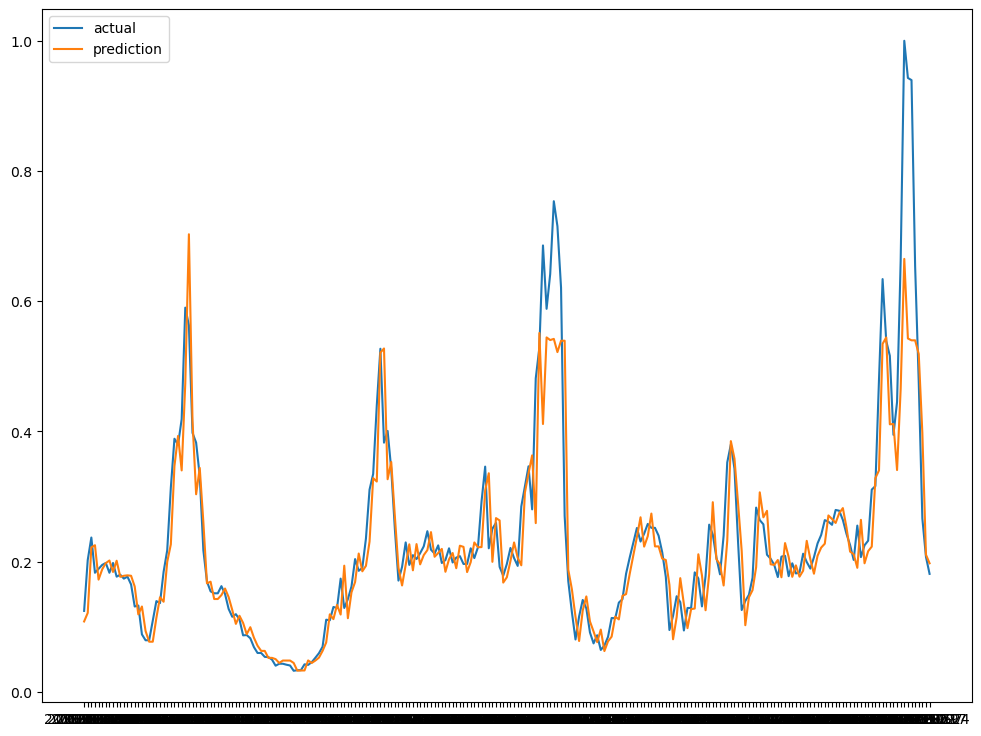

In [23]:
# 시각화
plt.figure(figsize=(12, 9))
plt.plot(test_y, label='actual')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.show()




Make new data

In [29]:
# 예측 데이터 생성
window_size= 5
num_list= []
for i in range(1, int(len(df_test)/window_size)+1):
    num_list.append(i*window_size)

candle_test_df= pd.DataFrame(columns=['시가', '고가', '저가', '종가', '날짜'])
for i in range(len(num_list)):
    candle_test_df.loc[i, '시가']= df_test.iloc[num_list[i]-window_size, 0]
    candle_test_df.loc[i, '고가']= df_test.iloc[num_list[i]-window_size:num_list[i], 0].max()
    candle_test_df.loc[i, '저가']= df_test.iloc[num_list[i]-window_size:num_list[i], 0].min()
    candle_test_df.loc[i, '종가']= df_test.iloc[num_list[i]-1, 0]
    # 종가에 해당하는 날짜를 인덱스로 넣어
    candle_test_df.loc[i, '날짜']= df_test.index[num_list[i]-1]

# shift(1) "종가_shift" 컬럼 생성
candle_test_df['종가_shift']= candle_test_df['종가'].shift(-1)


# candle_test_df 날짜 인덱스로 설정
candle_test_df.set_index('날짜', inplace=True)

# 결측치 제거
candle_test_df.dropna(inplace=True)

candle_test_df

,시가,고가,저가,종가,종가_shift
날짜,,,,,
2022-11-07,7350.0,7381.5,6835.5,7330.0,6724.0
2022-11-14,7193.5,7193.5,6724.0,6724.0,6300.0
2022-11-21,6684.0,7018.0,6300.0,6300.0,5664.0


In [47]:
feature= candle_test_df[['시가', '고가', '저가','종가']]
target= candle_test_df[['종가_shift']]

# feature, target 데이터 스케일링
feature_test_sc= scaler1.fit_transform(feature)
target_test_sc= scaler2.fit_transform(target)

feature_test_sc= pd.DataFrame(feature_test_sc, columns=feature.columns, index=feature.index)
target_test_sc= pd.DataFrame(target_test_sc, columns=target.columns, index=target.index)

feature_test_sc

,시가,고가,저가,종가
날짜,,,,
2022-11-07,1.000000,1.000000,1.000000,1.00000
2022-11-14,0.765015,0.482806,0.791783,0.41165
2022-11-21,0.000000,0.000000,0.000000,0.00000


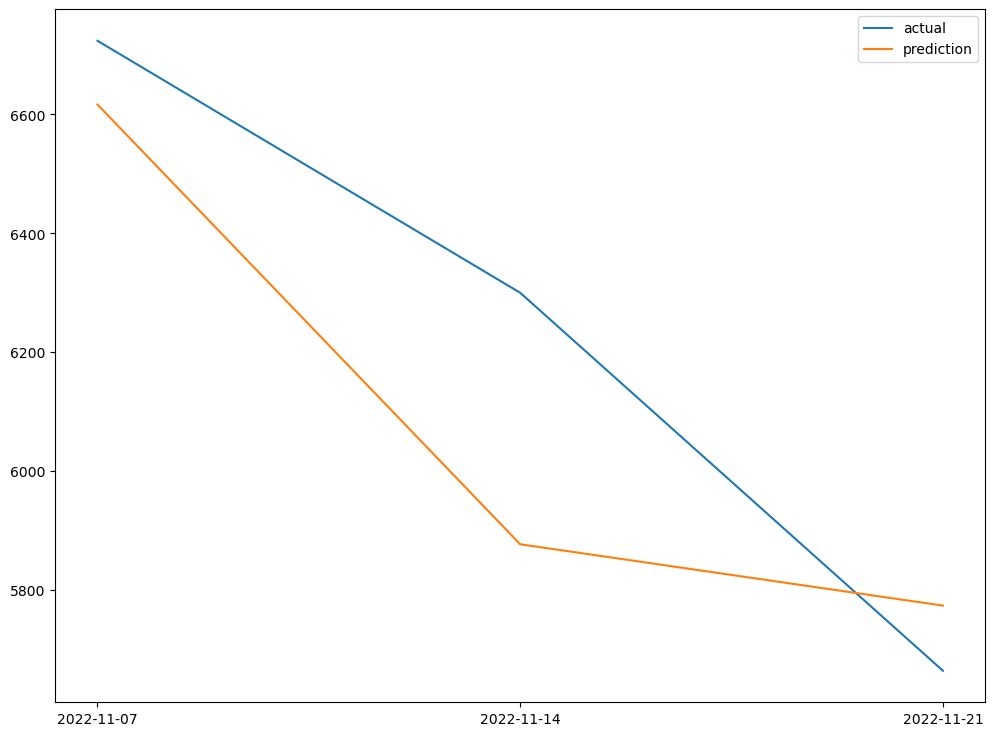

In [48]:
# 모델 불러오기
model= pickle.load(open('model/price_candle.pkl', 'rb'))

#예측
pred_test_y= model.predict(feature_test_sc)

# reshape
pred_test_y= pred_test_y.reshape(-1, 1)

# 예측 데이터 스케일링 복원
pred_test_y= scaler2.inverse_transform(pred_test_y)

# 실제 데이터 스케일링 복원
target_test_sc= scaler2.inverse_transform(target_test_sc)

# 예측 데이터 프레임 생성
pred_test_df= pd.DataFrame(pred_test_y, columns=['예측값'], index=feature_test_sc.index)

# 실제 데이터 프레임 생성
target_test_df= pd.DataFrame(target_test_sc, columns=['실제값'], index=feature_test_sc.index)

# 실제값, 예측값 데이터 프레임 병합
pred_test_df= pd.merge(pred_test_df, target_test_df, left_index=True, right_index=True)

#시각화
plt.figure(figsize=(12, 9))
plt.plot(pred_test_df['실제값'], label='actual')
plt.plot(pred_test_df['예측값'], label='prediction')
plt.legend()
plt.show()



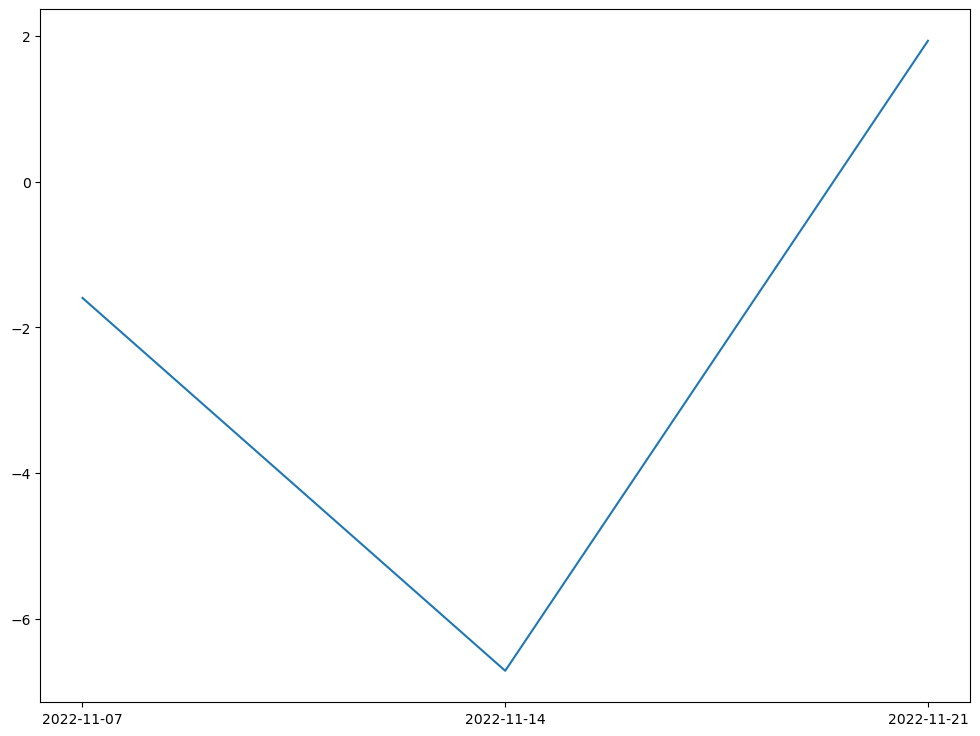

In [49]:
#  오차율 계산
pred_test_df['오차율']= (pred_test_df['예측값']-pred_test_df['실제값'])/pred_test_df['실제값']*100

# 오차율 시각화
plt.figure(figsize=(12, 9))
plt.plot(pred_test_df['오차율'])
plt.show()

